In [6]:
import sys
import sklearn
import matplotlib
import numpy as np
from datetime import datetime

from scipy import optimize
from numpy import log, exp
    
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import norm

import matplotlib.pyplot as plt
import keras
import tensorflow
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

import numpy as np
from matplotlib import pyplot as plt
import torchvision
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math


import time

import eagerpy as ep
import foolbox as fb
import foolbox.attacks as fa
from foolbox import PyTorchModel, accuracy, samples, plot, criteria, distances
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from matplotlib import patches

In [7]:
import warnings

warnings.filterwarnings('ignore')

In [8]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.burn_in = 5
        self.steps = 20
        self.eta = 0.2
        self.beta = 3

    def forward(self, x):
        print(x.detach().numpy().shape)
        x = self.denoise(x.detach().numpy(),self.burn_in,self.steps,self.eta,self.beta)
        x = torch.Tensor(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
    def get_posterior(self, images,burn_in,steps,eta,beta):
        posterior = np.zeros(images.shape)
        energy_list = list()
        for image_count in range(images.shape[0]):
            image = images[image_count][0]
            r = image
            for step in range(burn_in+steps):
                for i in range(1,r.shape[0]-1):
                    for j in range(1,r.shape[1]-1):
                        p = self.sample(i,j,r,image,eta,beta)
                        if step >= burn_in and p >= 0.5:
                            posterior[image_count][0][i,j] = posterior[image_count][0][i,j]+1
        posterior = 1.0 * posterior / steps
        return posterior

    def sample(self,i,j,r,image,eta,beta):
        neighbors = [r[i - 1, j], r[i, j - 1], r[i, j + 1], r[i + 1, j]]
        p = 1.0/(1+np.exp(-2*(eta * image[i,j] + beta * np.sum(neighbors))))
        return p

    def denoise(self,images,burn_in,steps,eta,beta):
        posterior = self.get_posterior(images,burn_in,steps,eta,beta)
        denoised = np.zeros(posterior.shape, dtype=np.float64)
        denoised[posterior >= 0.5] = 1
        denoised[posterior < 0.5] = -1
        return denoised
    
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)




(64, 1, 28, 28)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346671
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.305047
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.290859
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.283137
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301531
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 

(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.900959
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [26240/60000 (44%)]	Loss: 0.670058
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [26880/60000 (45%)]	Loss: 0.784532
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [27520/60000 (46%)]	Loss: 0.626938
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [

(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.561641
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.655807
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.781334
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.395338
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 1 [53120/60000 (88%

(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.515391
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.682443
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.330248
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 2 [17280/60000 (29%)]	Loss: 0.358373
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 2 [17920/60000 (30%)]	Loss: 0.455440
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28

(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 2 [40320/60000 (67%)]	Loss: 0.507563
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.324059
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.443414
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.305093
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.450021
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28

(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.372322
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.339410
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [7040/60000 (12%)]	Loss: 0.229097
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.364181
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [8320

(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.261431
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [31360/60000 (52%)]	Loss: 0.297042
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.397971
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.420157
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [33280/60000 (55%

(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.284058
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.321875
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [56960/60000 (95%)]	Loss: 0.142459
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.364469
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
Train Epoch: 3 [58240/60000 (97%)]	Loss: 0.31587

ValueError: x and y must be the same size

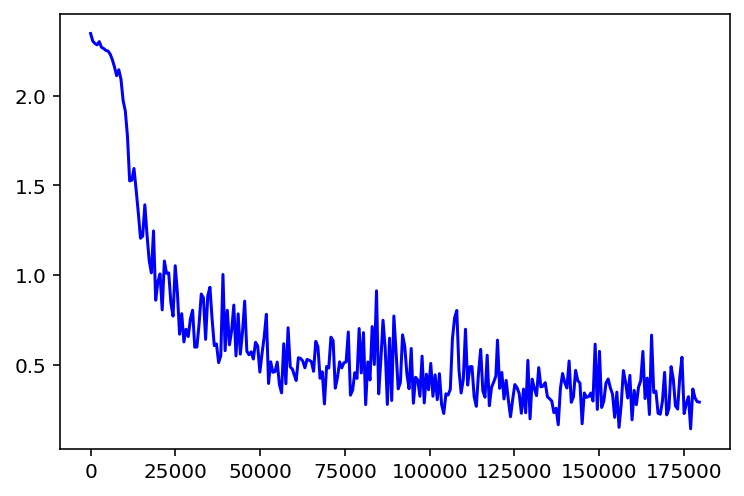

In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')
    
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

for epoch in range(1, n_epochs + 1):
  train(epoch)
  #test()
    
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)

Test set: Avg. loss: 0.1292, Accuracy: 9598/10000 (96%)



ValueError: x and y must be the same size

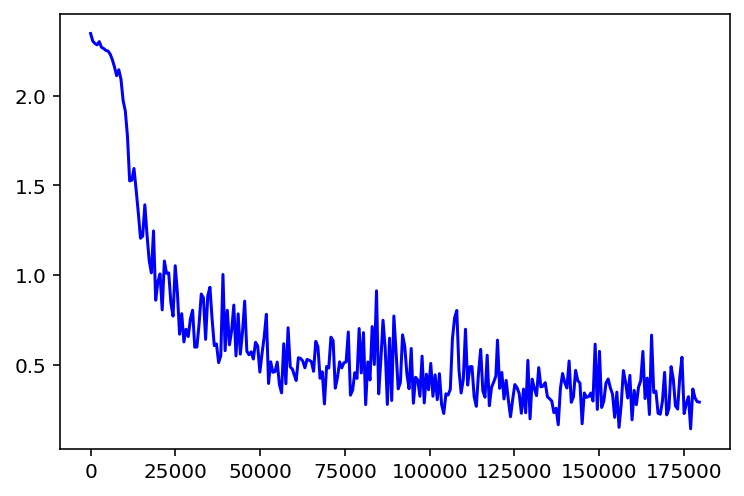

In [20]:
test()
    
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 28, 28)
(50, 1, 

KeyboardInterrupt: 

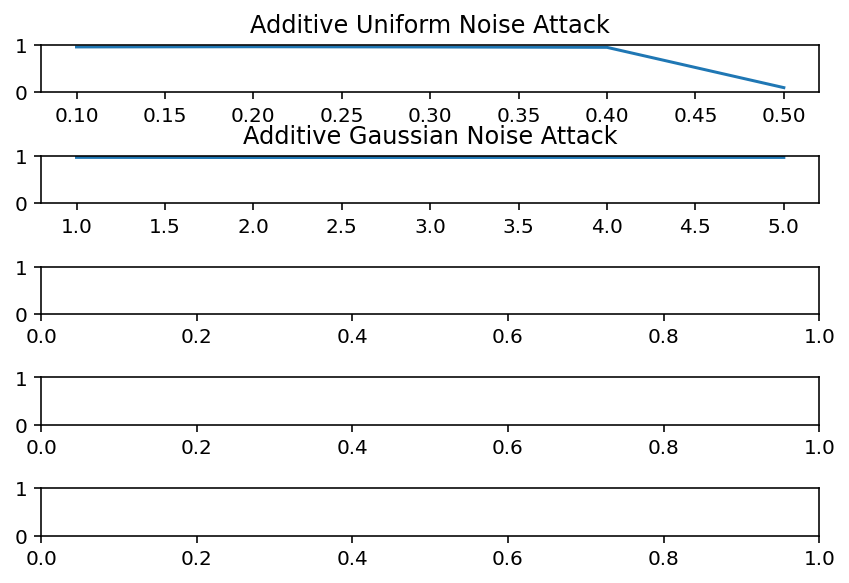

In [24]:
# -*- coding: utf-8 -*-
"""attack.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Jr7IbRTmPeJD40sliDG923iyJKAb5yMa
"""

def main():
    # Load your trained model as fb.PyTorchModel here
    #fmodel: Model = fb.TensorFlowModel(model, bounds=(0, 1))
    #fmodel = fb.TensorFlowModel(model, bounds=(0, 1))
    fmodel = fb.PyTorchModel(network, bounds=(0, 1))
    print(fmodel)
    #fmodel = model

    test_size = 1000  # assuming we are running 1000 tests for each attack
    batch_size = 50   # adjust your batch size according to memory limitation, as long as it's a divisor of 1000
    num_batch = int(test_size / batch_size)

    test_dataset = MNIST(root='./data', download=True, train=False, transform=transforms.ToTensor())
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

    Linf_epsilons = [
        0.1,
        0.2,
        0.3,
        0.4,
        0.5
    ]
    CW_epsilons = [
        0.1,
        1,
        10,
        100,
        1000
    ]
    L2_epsilons = [
        1,
        2,
        3,
        4,
        5
    ]
    attacks = [
        # gradient-based attacks
        #{"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack(), "epsilons": L2_epsilons},
        #{"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack(), "epsilons": Linf_epsilons},
        #{"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack(), "epsilons": L2_epsilons},
        #{"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack(), "epsilons": Linf_epsilons},
        #{"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack(), "epsilons": CW_epsilons},
        # # decision-based attacks
        #{"name": "Boundary Attack", "model": fa.BoundaryAttack(), "epsilons": L2_epsilons}, 
        {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack(), "epsilons": Linf_epsilons},
        {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack(), "epsilons": L2_epsilons},
        {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf), "epsilons": Linf_epsilons}, 
        {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf), "epsilons": Linf_epsilons}, 
        {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf), "epsilons": Linf_epsilons}
    ]

    fig, axs = plt.subplots(len(attacks))
    fig.tight_layout()

    for i, attack in enumerate(attacks):
        clean_accuracy = torch.zeros(num_batch)
        robust_accuracy_batch = torch.zeros([num_batch, len(L2_epsilons)])
        count = 0
        t1 = time.time()
        for images, labels in test_loader:
            if count == num_batch:
                break
            images = ep.astensor(images)
            labels = ep.astensor(labels)
            clean_accuracy[count] = fb.utils.accuracy(fmodel, images, labels)

            # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
            # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
            # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
            raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=attack["epsilons"])
            
            success_ = is_adv.numpy()
            robust_accuracy_batch[count] = torch.from_numpy(1.0 - success_.mean(axis=-1))

            count += 1

        t2 = time.time()
        print("Clean accuracy: {:.5f}".format(torch.mean(clean_accuracy)))
        print("Average time taken for each test: {} seconds".format((t2 - t1) / test_size))
        robust_accuracy = torch.mean(robust_accuracy_batch, dim=0)
        print("Accuracy with {} attack: {}".format(attack["name"], robust_accuracy))

        # plot the robust accuracy against epsilons for the particular attack
        axs[i].set_ylim([0, 1])
        axs[i].plot(attack["epsilons"], robust_accuracy.numpy())
        axs[i].set_title(attack["name"])


if __name__ == '__main__':
    main()